In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras import Model

In [2]:
df = pd.read_csv('..\\data\\processed2\\processed_data.csv', index_col=0)

In [3]:
inds = df.index[df['inning']<9]

In [4]:
df.loc[df['home_score']>12, 'home_score'] = 12

In [5]:
df.loc[df['visiting_score']>12, 'visiting_score'] = 12

In [6]:
df['event_final'] = df['event_final'].astype('category')
df['inning'] = df['inning'].astype('category')
df['home_score'] = df['home_score'].astype('category')
df['visiting_score'] = df['visiting_score'].astype('category')
df['outs'] = df['outs'].astype('category')

In [7]:
df['event_final_code'] = df['event_final'].cat.codes
df['inning_code'] = df['inning'].cat.codes
df['home_score_code'] = df['home_score'].cat.codes
df['visiting_score_code'] = df['visiting_score'].cat.codes
df['outs_code'] = df['outs'].cat.codes

In [8]:
first = [0]*len(df)
second = [0]*len(df)
third = [0]*len(df)
for i in df.index:
    if isinstance(df.loc[i, '1st runner'], str):
        first[i] = 1
    if isinstance(df.loc[i, '2nd runner'], str):
        second[i] = 1
    if isinstance(df.loc[i, '3rd runner'], str):
        third[i] = 1
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [9]:
first = np.array(first)
second = np.array(second)
third = np.array(third)

In [10]:
df['first'] = first
df['second'] = second
df['third'] = third

In [11]:
situation = df[['inning', 'batting team', 'outs', 'visiting_score', 'home_score', 'first', 'second', 'third']].values
batter = df['res batter'].values
pitcher = df['res pitcher'].values
balls = df['balls'].values
strikes = df['strikes'].values
fouls = df['fouls'].values
outcome = df['event_final_code'].values
outcome_onehot = pd.get_dummies(df['event_final_code']).values
inning_onehot = pd.get_dummies(df['inning_code']).values
home_score_onehot = pd.get_dummies(df['home_score_code']).values
visiting_score_onehot = pd.get_dummies(df['visiting_score_code']).values
outs_onehot = pd.get_dummies(df['outs_code']).values

In [12]:
situation[:, 0] -= 1

In [13]:
samples = inds.shape[0]-1

p = np.random.permutation(samples)
train_inds = inds[p[:samples//5 * 4]]
test_inds = inds[p[samples//5 * 4:]]

In [14]:
situation_train = situation[train_inds]
outcome_train = outcome_onehot[train_inds]
y_train = [inning_onehot[train_inds+1, :9].astype(float), 
           df['batting team'].values[train_inds+1].astype(float), 
           outs_onehot[train_inds+1].astype(float), 
           visiting_score_onehot[train_inds+1].astype(float), 
           home_score_onehot[train_inds+1].astype(float),
           first[train_inds+1].astype(float),
           second[train_inds+1].astype(float),
           third[train_inds+1].astype(float)]

situation_test = situation[test_inds]
outcome_test = outcome_onehot[test_inds]
y_test = [inning_onehot[test_inds+1, :9].astype(float), 
          df['batting team'].values[test_inds+1].astype(float), 
          outs_onehot[test_inds+1].astype(float), 
          visiting_score_onehot[test_inds+1].astype(float), 
          home_score_onehot[test_inds+1].astype(float),
          first[test_inds+1].astype(float),
          second[test_inds+1].astype(float),
          third[test_inds+1].astype(float)]

In [15]:
X_train = np.concatenate((situation_train, outcome_train), axis=1).astype(float)
X_test = np.concatenate((situation_test, outcome_test), axis=1).astype(float)

In [23]:
def build_model(shape_in, hidden, activations):
    
    X = Input(shape=(shape_in,))
    
    X_int = Dense(hidden, activation=activations)(X)

    X_int = Dense(hidden, activation=activations)(X)

    X_int = Dropout(0.2)(X_int)

    inning = Dense(9, activation='softmax')(X_int)

    half_inning = Dense(1, activation='sigmoid')(X_int)

    outs = Dense(3, activation='softmax')(X_int)

    visiting_score = Dense(13, activation='softmax')(X_int)

    home_score = Dense(13, activation='softmax')(X_int)

    first = Dense(1, activation='sigmoid')(X_int)

    second = Dense(1, activation='sigmoid')(X_int)

    third = Dense(1, activation='sigmoid')(X_int)

    return Model(inputs=[X], 
                 outputs=[inning, half_inning, outs, visiting_score, home_score, first, second, third])

In [24]:
model = build_model(X_train.shape[1], 128, 'relu')

In [25]:
def compile_model(model, LR):
    adam = tf.keras.optimizers.Adam(lr=LR)
    model.compile(
        optimizer=adam,
        loss=['categorical_crossentropy', 'binary_crossentropy', 'categorical_crossentropy',
            'categorical_crossentropy', 'categorical_crossentropy', 'binary_crossentropy',
            'binary_crossentropy', 'binary_crossentropy'],
        metrics=['accuracy']*8)
    return model

In [26]:
model = compile_model(model, 1e-2)
for i in range(200):
    if i == 100:
        model = compile_model(model, 1e-3)
    print('epoch: '+str(i+1))
    model.fit(x=X_train,
              y=y_train, 
              batch_size=X_train.shape[0]//20,
              epochs=1,
              verbose=1)

ss: 1.1714 - dense_12_loss: 0.0994 - dense_13_loss: 0.0817 - dense_14_loss: 0.1646 - dense_15_loss: 0.1538 - dense_16_loss: 0.1837 - dense_17_loss: 0.1871 - dense_18_loss: 0.1805 - dense_19_loss: 0.1367 - dense_12_accuracy: 0.9712 - dense_13_accuracy: 0.9748 - dense_14_accuracy: 0.9523 - dense_15_accuracy: 0.9457 - dense_16_accuracy: 0.9341 - dense_17_accuracy: 0.9427 - dense_18_accuracy: 0.9326 - dense_19_accuracy: 0.9429
epoch: 164
Train on 649548 samples
649548/649548 [==============================] - 4s 6us/sample - loss: 1.1814 - dense_12_loss: 0.1022 - dense_13_loss: 0.0734 - dense_14_loss: 0.1612 - dense_15_loss: 0.1566 - dense_16_loss: 0.1916 - dense_17_loss: 0.1753 - dense_18_loss: 0.1760 - dense_19_loss: 0.1276 - dense_12_accuracy: 0.9706 - dense_13_accuracy: 0.9740 - dense_14_accuracy: 0.9513 - dense_15_accuracy: 0.9456 - dense_16_accuracy: 0.9336 - dense_17_accuracy: 0.9395 - dense_18_accuracy: 0.9318 - dense_19_accuracy: 0.9427
epoch: 165
Train on 649548 samples
649548/64

In [27]:

[loss, l1, l2, l3, l4, l5, l6, l7, l8, 
 inning_acc, half_inning_acc, outs_acc, 
 visiting_score_acc, home_score_acc, 
 first_acc, second_acc, third_acc] = model.evaluate(X_test, y_test, batch_size=X_test.shape[0]//20)

162388/162388 [==============================] - 1s 6us/sample - loss: 0.8960 - dense_12_loss: 0.0444 - dense_13_loss: 0.0558 - dense_14_loss: 0.1351 - dense_15_loss: 0.0867 - dense_16_loss: 0.1122 - dense_17_loss: 0.1736 - dense_18_loss: 0.1671 - dense_19_loss: 0.1236 - dense_12_accuracy: 0.9889 - dense_13_accuracy: 0.9800 - dense_14_accuracy: 0.9584 - dense_15_accuracy: 0.9760 - dense_16_accuracy: 0.9707 - dense_17_accuracy: 0.9449 - dense_18_accuracy: 0.9401 - dense_19_accuracy: 0.9506


In [28]:
print('inning accuracy: '+str(inning_acc))
print('half inning accuracy: '+str(half_inning_acc))
print('outs accuracy: '+str(outs_acc))
print('visiting score accuracy: '+str(visiting_score_acc))
print('home score accuracy: '+str(home_score_acc))
print('first accuracy: '+str(first_acc))
print('second accuracy: '+str(second_acc))
print('third accuracy: '+str(third_acc))

inning accuracy: 0.9889339
half inning accuracy: 0.97998005
outs accuracy: 0.95841444
visiting score accuracy: 0.97596496
home score accuracy: 0.9706752
first accuracy: 0.9448851
second accuracy: 0.9400633
third accuracy: 0.9505752


In [39]:
print('inning accuracy: '+str(inning_acc))
print('half inning accuracy: '+str(half_inning_acc))
print('outs accuracy: '+str(outs_acc))
print('visiting score accuracy: '+str(visiting_score_acc))
print('home score accuracy: '+str(home_score_acc))
print('first accuracy: '+str(first_acc))
print('second accuracy: '+str(second_acc))
print('third accuracy: '+str(third_acc))

inning accuracy: 0.9890386
half inning accuracy: 0.97872996
outs accuracy: 0.96033573
visiting score accuracy: 0.9654654
home score accuracy: 0.9630638
first accuracy: 0.9447681
second accuracy: 0.9367441
third accuracy: 0.94341946


In [29]:
y_pred = model(X_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [30]:
y_pred = np.concatenate((y_pred), axis=1)

In [31]:
model.save('..\\models\\situation_prediction_relu')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ..\models\situation_prediction_relu\assets
INFO:tensorflow:Assets written to: ..\models\situation_prediction_relu\assets


In [32]:
model2 = tf.keras.models.load_model('..\\models\\situation_prediction_relu')

In [33]:
cats = df['event_final'].astype('category')

outcome_dict = {}
for i, cat in enumerate(cats.cat.categories):
    outcome_dict[cat] = i
outcome_dict_rev = dict(enumerate(cats.cat.categories))
N_outcomes = len(outcome_dict)

In [34]:
outcome_dict

{'1B': 0,
 '1G': 1,
 '1L': 2,
 '1SH': 3,
 '2B': 4,
 '2G': 5,
 '2P': 6,
 '2SH': 7,
 '34G': 8,
 '3B': 9,
 '3G': 10,
 '3L': 11,
 '3P': 12,
 '3SH': 13,
 '4G': 14,
 '4L': 15,
 '4P': 16,
 '5B': 17,
 '5G': 18,
 '5L': 19,
 '5P': 20,
 '5SH': 21,
 '6G': 22,
 '6L': 23,
 '6P': 24,
 '7F': 25,
 '7L': 26,
 '7SF': 27,
 '8F': 28,
 '8L': 29,
 '8SF': 30,
 '9F': 31,
 '9L': 32,
 '9SF': 33,
 'C': 34,
 'D4G': 35,
 'D5G': 36,
 'D7F': 37,
 'D7G': 38,
 'D7L': 39,
 'D8F': 40,
 'D8G': 41,
 'D8L': 42,
 'D9F': 43,
 'D9G': 44,
 'D9L': 45,
 'DG7': 46,
 'DG8': 47,
 'DG9': 48,
 'FC1': 49,
 'FC2': 50,
 'FC3': 51,
 'FC4': 52,
 'FC5': 53,
 'FC6': 54,
 'H': 55,
 'H7': 56,
 'H78': 57,
 'H8': 58,
 'H89': 59,
 'H9': 60,
 'IW': 61,
 'K': 62,
 'S1B': 63,
 'S1G': 64,
 'S1L': 65,
 'S2B': 66,
 'S2G': 67,
 'S3B': 68,
 'S3G': 69,
 'S3L': 70,
 'S3P': 71,
 'S4B': 72,
 'S4G': 73,
 'S4L': 74,
 'S4P': 75,
 'S5B': 76,
 'S5G': 77,
 'S5L': 78,
 'S6B': 79,
 'S6G': 80,
 'S6L': 81,
 'S6P': 82,
 'S7F': 83,
 'S7G': 84,
 'S7L': 85,
 'S8F': 86,
 '

In [87]:
def update_situation(situation, outcome, model=model2):
    situation['inning'] -= 1
    vals = np.array(list(situation.values()))
    X = np.append(vals, outcome)
    pred = model(X.reshape(1, -1))
    pred = [np.squeeze(p.numpy()) for p in pred]
    valid = False
    while not valid:
        inning = np.random.choice(pred[0].shape[0], p=pred[0]) + 1
        half_inning = np.random.choice(2, p=[1-pred[1], pred[1]])
        outs = np.random.choice(pred[2].shape[0], p=pred[2])
        visiting_score = np.random.choice(pred[3].shape[0], p=pred[3])
        home_score = np.random.choice(pred[4].shape[0], p=pred[4])
        first = np.random.choice(2, p=[1-pred[5], pred[5]])
        second = np.random.choice(2, p=[1-pred[6], pred[6]])
        third = np.random.choice(2, p=[1-pred[7], pred[7]])
        situation_out = {'inning' : inning,
                        'half inning' : half_inning,
                        'outs' : outs,
                        'visiting score' : visiting_score,
                        'home score' : home_score,
                        'first' : first,
                        'second' : second,
                        'third' : third}
        valid = compare_situation(situation, situation_out)
        if not valid:
            print('reject')
    return situation_out, pred

def compare_situation(situation, update):
    if update['inning'] < situation['inning']:
        print('inning_order')
        return False
    elif update['visiting score'] < situation['visiting score']:
        print('visiting score')
        return False
    elif update['home score'] < situation['home score']:
        print('home score')
        return False
    elif update['half inning'] != situation['half inning']:
        if update['outs'] != 0:
            print('reset outs')
            return False
        elif (not update['half inning']) & (update['inning'] - situation['inning'] != 1):
            print('reset outs')
            return False
        elif update['first'] or update['second'] or update['third']:
            print('reset base runners')
            return False
        else:
            return True
    elif (not situation['half inning']) & (update['home score'] - situation['home score'] != 0):
        print('home score changing in top of inning')
        return False
    elif (situation['half inning']) & (update['visiting score'] - situation['visiting score'] != 0):
        print('visiting score changing in bottom of inning')
        return False 
    else:
        return True


In [88]:
def get_sit_feed(X, outcome_dict):
    sit_feed = {'inning' : int(round(X[0]) + 1),
                'half inning' : int(round(X[1])),
                'outs' : int(round(X[2])),
                'visiting score' : int(round(X[3])),
                'home score' : int(round(X[4])),
                'first' : int(round(X[5])),
                'second' : int(round(X[6])),
                'third' : int(round(X[7]))}
    outcome_onehot = np.where(X[8:])[0][0]
    return sit_feed, outcome_dict[outcome_onehot]

def get_sit_out_test(y_test, ind):
    test = [t[ind] for t in y_test]
    sit_out = {'inning' : np.where(test[0])[0][0]+1,
                'half inning' : int(round(test[1])),
                'outs' : np.where(test[2])[0][0],
                'visiting score' : np.where(test[3])[0][0],
                'home score' : np.where(test[4])[0][0],
                'first' : int(round(test[5])),
                'second' : int(round(test[6])),
                'third' : int(round(test[7]))}
    return sit_out

In [92]:
ind = 11002
sit_feed, outcome = get_sit_feed(X_test[ind], outcome_dict_rev)
print(sit_feed)

{'inning': 7, 'half inning': 0, 'outs': 0, 'visiting score': 1, 'home score': 10, 'first': 0, 'second': 0, 'third': 0}


In [93]:
sit_out = get_sit_out_test(y_test, ind)
outcome_feed = np.zeros((N_outcomes))
outcome_feed[outcome_dict[outcome]] += 1
sit_pred, pred = update_situation(sit_feed, outcome_feed)
print(outcome)
print(sit_out)
print(sit_pred)

home score
reject
3G
{'inning': 7, 'half inning': 0, 'outs': 1, 'visiting score': 1, 'home score': 10, 'first': 0, 'second': 0, 'third': 0}
{'inning': 7, 'half inning': 0, 'outs': 1, 'visiting score': 1, 'home score': 10, 'first': 0, 'second': 0, 'third': 0}


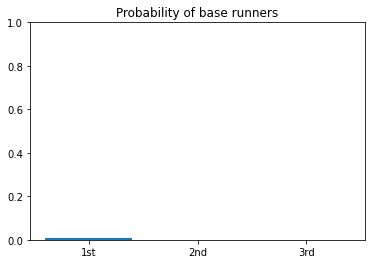

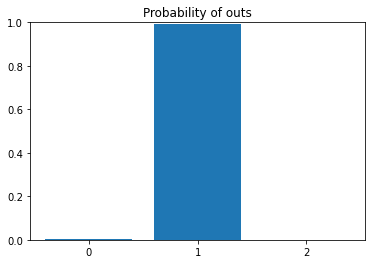

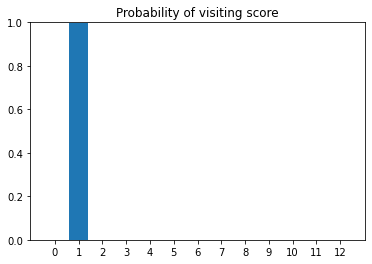

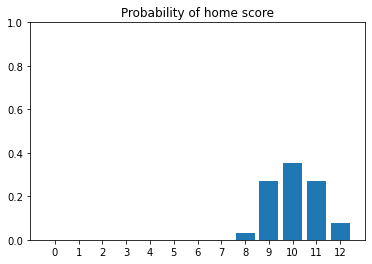

In [94]:
plt.bar(np.arange(3), [pred[5], pred[6], pred[7]])
plt.ylim([0, 1])
plt.xticks(np.arange(3), ['1st', '2nd', '3rd'])
plt.title('Probability of base runners')
plt.show()

plt.bar(np.arange(3), pred[2])
plt.ylim([0, 1])
plt.xticks(np.arange(3), ['0', '1', '2'])
plt.title('Probability of outs')
plt.show()

plt.bar(np.arange(13), pred[3])
plt.ylim([0, 1])
plt.xticks(np.arange(13), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.title('Probability of visiting score')
plt.show()

plt.bar(np.arange(13), pred[4])
plt.ylim([0, 1])
plt.xticks(np.arange(13), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.title('Probability of home score')
plt.show()